# Libraries

In [1]:
import gdown
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split

# Data Information

In [2]:
train_file_id = '1Z1wlnO6VyN2ecZVLr1025XMgooON06b5'
train_output_file = '/content/train.csv'
train_download_url = f'https://drive.google.com/uc?id={train_file_id}'
gdown.download(train_download_url, train_output_file, quiet=False)
df = pd.read_csv(train_output_file)

Downloading...
From: https://drive.google.com/uc?id=1Z1wlnO6VyN2ecZVLr1025XMgooON06b5
To: /content/train.csv
100%|██████████| 48.7k/48.7k [00:00<00:00, 49.2MB/s]


In [3]:
df.head()

,Year,Month,Day,Time of Tweet,text,sentiment,Platform
0,2018,8,18,morning,What a great day!!! Looks like dream.,positive,Twitter
1,2018,8,18,noon,"I feel sorry, I miss you here in the sea beach",positive,Facebook
2,2017,8,18,night,Don't angry me,negative,Facebook
3,2022,6,8,morning,We attend in the class just for listening teac...,negative,Facebook
4,2022,6,8,noon,"Those who want to go, let them go",negative,Instagram


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499 entries, 0 to 498
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Year           499 non-null    int64 
 1   Month          499 non-null    int64 
 2   Day            499 non-null    int64 
 3   Time of Tweet  499 non-null    object
 4   text           499 non-null    object
 5   sentiment      499 non-null    object
 6   Platform       499 non-null    object
dtypes: int64(3), object(4)
memory usage: 27.4+ KB


In [5]:
obj = [col for col in df.columns if df[col].nunique() <= 10]
for col in obj:
  print(f"====={col}=====")
  unique_values = df[col].unique()
  n_unique_values = df[col].nunique()
  value_counts = df[col].value_counts()

  print(f"Unique values in {col}: {unique_values}")
  print(f"Number of unique values in {col}: {n_unique_values}\n")
  print(f"Value counts in {col}:\n{value_counts}\n")

=====Time of Tweet=====
Unique values in Time of Tweet: ['morning' 'noon' 'night']
Number of unique values in Time of Tweet: 3

Value counts in Time of Tweet:
Time of Tweet
morning    171
noon       167
night      161
Name: count, dtype: int64

=====sentiment=====
Unique values in sentiment: ['positive' 'negative' 'neutral']
Number of unique values in sentiment: 3

Value counts in sentiment:
sentiment
neutral     199
positive    166
negative    134
Name: count, dtype: int64

=====Platform=====
Unique values in Platform: [' Twitter  ' ' Facebook ' 'Facebook' ' Instagram ' ' Twitter ']
Number of unique values in Platform: 5

Value counts in Platform:
Platform
 Instagram     171
 Facebook      165
 Twitter        91
 Twitter        68
Facebook         4
Name: count, dtype: int64



# Data Cleaning

In [6]:
df.duplicated().sum()

105

In [7]:
# df = df.drop_duplicates()

# EDA Before Preprocessing

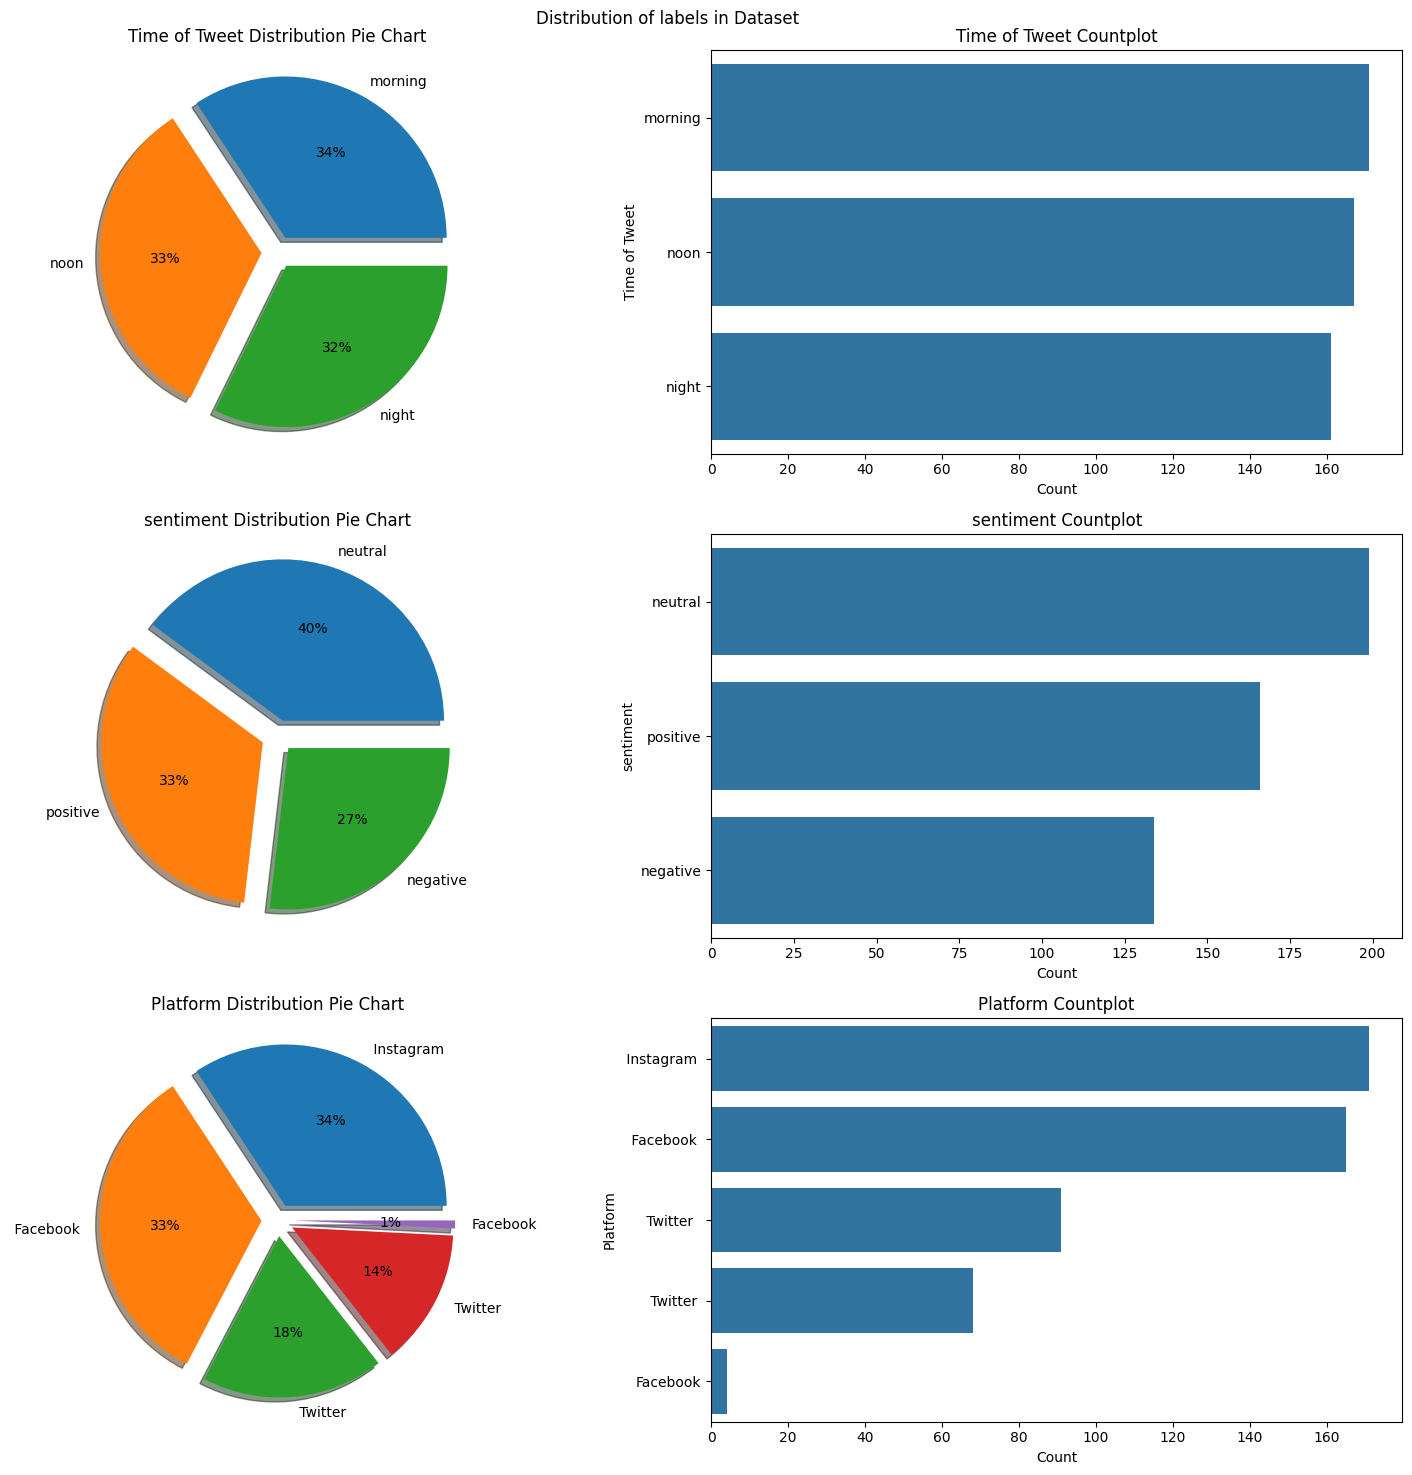

In [8]:
obj = [col for col in df.columns if df[col].nunique() <= 10]
fig, axes = plt.subplots(3,2, figsize = (15, 15))

for i, col in enumerate(obj):
  ax = axes[i, 0]
  ax.pie(
      df[col].value_counts(),
      shadow = True,
      explode = [0.1 for _ in range(df[col].nunique())],
      autopct='%1.f%%',
      labels = df[col].value_counts().index
  )

  ax.set_aspect('equal')
  ax.set_title(f'{col} Distribution Pie Chart')

  ax1 = axes[i, 1]
  sns.countplot(y=col, ax=ax1, order=df[col].value_counts().index, data=df)
  ax1.set_xlabel('Count')
  ax1.set_ylabel(col)
  ax1.set_title(f'{col} Countplot')

fig.suptitle('Distribution of labels in Dataset')
plt.tight_layout()
plt.show()

## Length Count

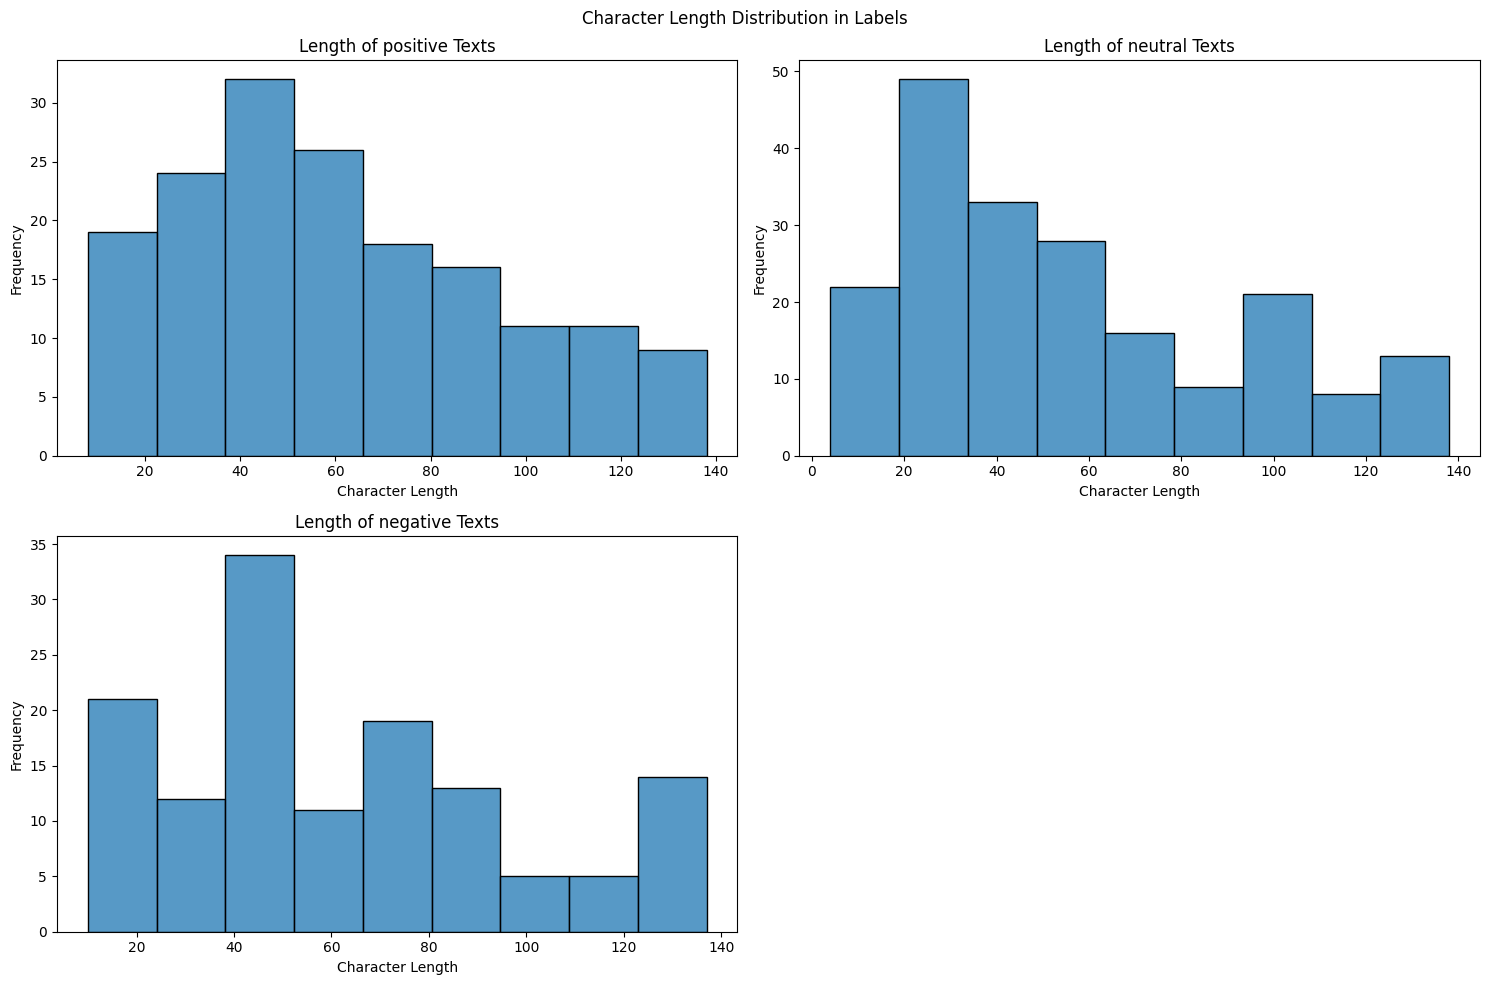

In [9]:
labels = ['positive', 'neutral', 'negative']

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, label in enumerate(labels):
  length_text = df[df['sentiment'] == label]['text'].str.len()
  ax = sns.histplot(length_text, ax=axes[i])
  ax.set_title(f'Length of {label} Texts')
  ax.set_xlabel('Character Length')
  ax.set_ylabel('Frequency')

for j in range(len(labels), len(axes)):
    fig.delaxes(axes[j])

fig.suptitle('Character Length Distribution in Labels')
plt.tight_layout()
plt.show()

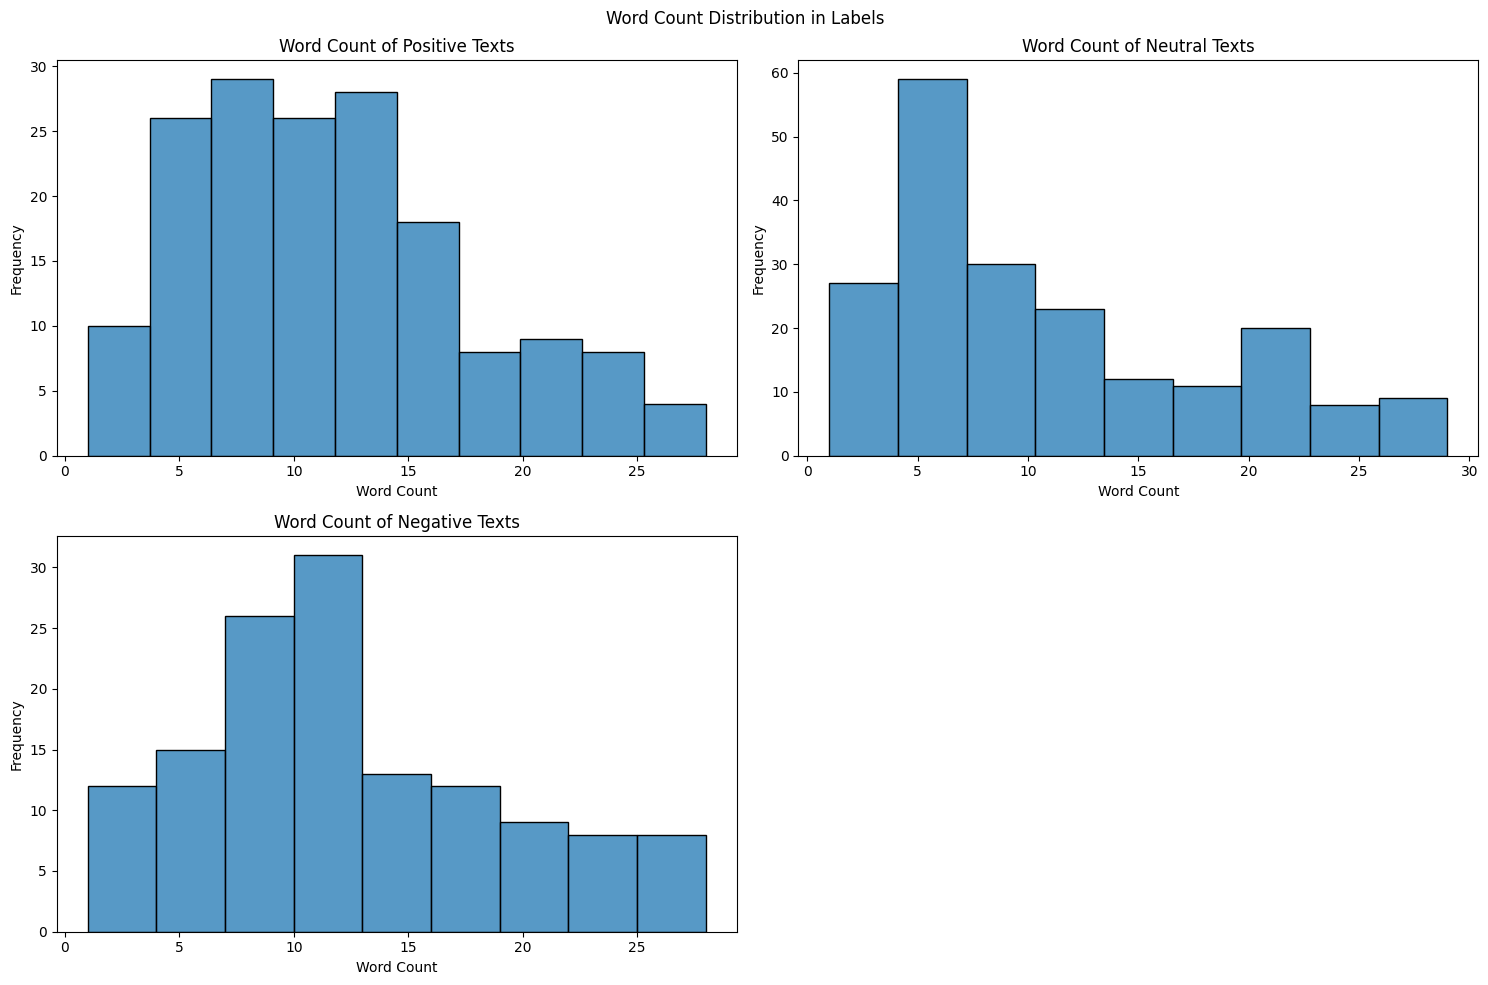

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, label in enumerate(labels):
  word_count = df[df['sentiment'] == label]['text'].apply(lambda x: len(str(x).split()))
  ax = sns.histplot(word_count, ax=axes[i], kde=False)
  ax.set_title(f'Word Count of {label.capitalize()} Texts')
  ax.set_xlabel('Word Count')
  ax.set_ylabel('Frequency')

for j in range(len(labels), len(axes)):
    fig.delaxes(axes[j])

fig.suptitle('Word Count Distribution in Labels')
plt.tight_layout()
plt.show()

# Data Preprocessing

## Text Cleaning

In [11]:
punc = string.punctuation

def text_cleaning(text):
    # Menghapus tanda baca
    text = "".join([i for i in text if i not in punc])

    # Mengubah teks menjadi huruf kecil
    text = text.lower()

    # Menghapus teks dalam tanda kurung siku
    text = re.sub('\[.*?\]', '', text)

    # Menghapus karakter non-kata (misalnya tanda baca yang tersisa)
    text = re.sub("\\W", " ", text)

    # Menghapus URL
    text = re.sub('https?://\S+|www\.\S+', '', text)

    # Menghapus tag HTML
    text = re.sub('<.*?>+', '', text)

    # Menghapus tanda baca yang tersisa
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)

    # Menghapus karakter newline
    text = re.sub('\n', '', text)

    # Menghapus kata yang mengandung angka
    text = re.sub('\w*\d\w*', '', text)

    return text

df['clean_text'] = df['text'].apply(text_cleaning)
df.head()

,Year,Month,Day,Time of Tweet,text,sentiment,Platform,clean_text
0,2018,8,18,morning,What a great day!!! Looks like dream.,positive,Twitter,what a great day looks like dream
1,2018,8,18,noon,"I feel sorry, I miss you here in the sea beach",positive,Facebook,i feel sorry i miss you here in the sea beach
2,2017,8,18,night,Don't angry me,negative,Facebook,dont angry me
3,2022,6,8,morning,We attend in the class just for listening teac...,negative,Facebook,we attend in the class just for listening teac...
4,2022,6,8,noon,"Those who want to go, let them go",negative,Instagram,those who want to go let them go


## Tokenize

In [12]:
nltk.download('punkt')
df['clean_text'] = df['clean_text'].astype(str)

def tokenize(text):
  token = word_tokenize(text)
  return token

df['clean_text'] = df['clean_text'].apply(tokenize)
df.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


,Year,Month,Day,Time of Tweet,text,sentiment,Platform,clean_text
0,2018,8,18,morning,What a great day!!! Looks like dream.,positive,Twitter,"[what, a, great, day, looks, like, dream]"
1,2018,8,18,noon,"I feel sorry, I miss you here in the sea beach",positive,Facebook,"[i, feel, sorry, i, miss, you, here, in, the, ..."
2,2017,8,18,night,Don't angry me,negative,Facebook,"[dont, angry, me]"
3,2022,6,8,morning,We attend in the class just for listening teac...,negative,Facebook,"[we, attend, in, the, class, just, for, listen..."
4,2022,6,8,noon,"Those who want to go, let them go",negative,Instagram,"[those, who, want, to, go, let, them, go]"


## Stopwords

In [13]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def stopword(words):
  words = [word for word in words if word not in stop_words]
  return words

df['clean_text'] = df['clean_text'].apply(stopword)
df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,Year,Month,Day,Time of Tweet,text,sentiment,Platform,clean_text
0,2018,8,18,morning,What a great day!!! Looks like dream.,positive,Twitter,"[great, day, looks, like, dream]"
1,2018,8,18,noon,"I feel sorry, I miss you here in the sea beach",positive,Facebook,"[feel, sorry, miss, sea, beach]"
2,2017,8,18,night,Don't angry me,negative,Facebook,"[dont, angry]"
3,2022,6,8,morning,We attend in the class just for listening teac...,negative,Facebook,"[attend, class, listening, teachers, reading, ..."
4,2022,6,8,noon,"Those who want to go, let them go",negative,Instagram,"[want, go, let, go]"


### Drop Unnecessary Value

In [14]:
def drop(words):
  words = [word for word in words if word not in ['ve', 't', 's']]
  return words

df['clean_text'] = df['clean_text'].apply(drop)
df = df[df['clean_text'].apply(lambda x: len(x) > 0)]
df.head()

,Year,Month,Day,Time of Tweet,text,sentiment,Platform,clean_text
0,2018,8,18,morning,What a great day!!! Looks like dream.,positive,Twitter,"[great, day, looks, like, dream]"
1,2018,8,18,noon,"I feel sorry, I miss you here in the sea beach",positive,Facebook,"[feel, sorry, miss, sea, beach]"
2,2017,8,18,night,Don't angry me,negative,Facebook,"[dont, angry]"
3,2022,6,8,morning,We attend in the class just for listening teac...,negative,Facebook,"[attend, class, listening, teachers, reading, ..."
4,2022,6,8,noon,"Those who want to go, let them go",negative,Instagram,"[want, go, let, go]"


## Lemmatizer

In [15]:
nltk.download('wordnet')
lm = WordNetLemmatizer()

def lemmatizer(words):
  return [lm.lemmatize(word) for word in words]

df['clean_text'] = df['clean_text'].apply(lemmatizer)
df.head()

[nltk_data] Downloading package wordnet to /root/nltk_data...


,Year,Month,Day,Time of Tweet,text,sentiment,Platform,clean_text
0,2018,8,18,morning,What a great day!!! Looks like dream.,positive,Twitter,"[great, day, look, like, dream]"
1,2018,8,18,noon,"I feel sorry, I miss you here in the sea beach",positive,Facebook,"[feel, sorry, miss, sea, beach]"
2,2017,8,18,night,Don't angry me,negative,Facebook,"[dont, angry]"
3,2022,6,8,morning,We attend in the class just for listening teac...,negative,Facebook,"[attend, class, listening, teacher, reading, s..."
4,2022,6,8,noon,"Those who want to go, let them go",negative,Instagram,"[want, go, let, go]"


In [16]:
df['clean_text'] = df['clean_text'].apply(lambda x: " ".join(x))
df.head()

,Year,Month,Day,Time of Tweet,text,sentiment,Platform,clean_text
0,2018,8,18,morning,What a great day!!! Looks like dream.,positive,Twitter,great day look like dream
1,2018,8,18,noon,"I feel sorry, I miss you here in the sea beach",positive,Facebook,feel sorry miss sea beach
2,2017,8,18,night,Don't angry me,negative,Facebook,dont angry
3,2022,6,8,morning,We attend in the class just for listening teac...,negative,Facebook,attend class listening teacher reading slide n...
4,2022,6,8,noon,"Those who want to go, let them go",negative,Instagram,want go let go


# WordCloud

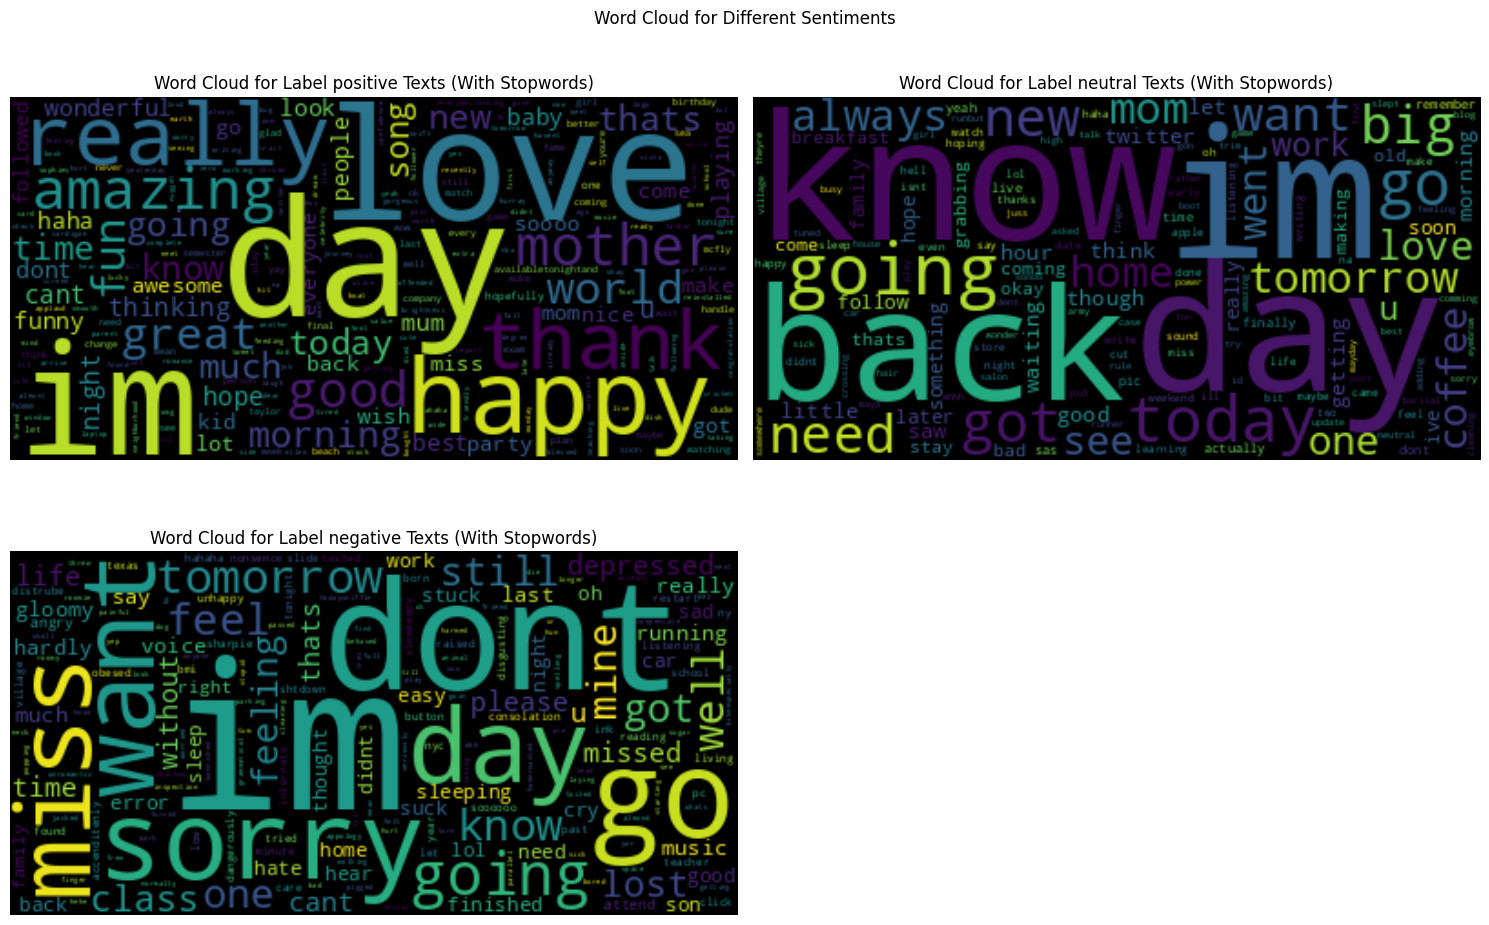

In [17]:
labels = ['positive', 'neutral', 'negative']

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, lab in enumerate(labels):
  opi = ' '.join(df[df['sentiment'] == lab]['clean_text'])
  ax = axes[i]
  wordcloud = WordCloud(max_words=2000, width=400, height=200, collocations=False).generate(opi)
  ax.imshow(wordcloud, interpolation='bilinear')
  ax.axis("off")
  ax.set_title(f"Word Cloud for Label {lab} Texts (With Stopwords)")

for j in range(len(labels), len(axes)):
    fig.delaxes(axes[j])

fig.suptitle('Word Cloud for Different Sentiments')
plt.tight_layout()
plt.show()

# Modelling

## Encoding

In [18]:
category_map = {
    'neutral': 0,
    'positive': 1,
    'negative': 2
}

df['sentiment'] = df['sentiment'].map(category_map)
df.head()

,Year,Month,Day,Time of Tweet,text,sentiment,Platform,clean_text
0,2018,8,18,morning,What a great day!!! Looks like dream.,1,Twitter,great day look like dream
1,2018,8,18,noon,"I feel sorry, I miss you here in the sea beach",1,Facebook,feel sorry miss sea beach
2,2017,8,18,night,Don't angry me,2,Facebook,dont angry
3,2022,6,8,morning,We attend in the class just for listening teac...,2,Facebook,attend class listening teacher reading slide n...
4,2022,6,8,noon,"Those who want to go, let them go",2,Instagram,want go let go


## Train Test Split

In [19]:
X = df['text']
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 42)

## Vectorizer

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectoriser = TfidfVectorizer()
X_train = vectoriser.fit_transform(X_train)
X_test  = vectoriser.transform(X_test)

In [21]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, classification_report

model = SVC()
model.fit(X_train, y_train)

y_pred_cls = model.predict(X_test)
accuracy_cls = accuracy_score(y_test, y_pred_cls)
f1_cls = f1_score(y_test, y_pred_cls, average='weighted')
report_cls = classification_report(y_test, y_pred_cls)

print(f"Model: SVM")
print(f"Accuracy: {accuracy_cls:.4f}")
print(f"F1-Score: {f1_cls:.4f}")
print(f"Classification Report:\n{report_cls}")
print("="*50)

Model: SVM
Accuracy: 0.6200
F1-Score: 0.6038
Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.90      0.67        40
           1       0.79      0.50      0.61        30
           2       0.85      0.37      0.51        30

    accuracy                           0.62       100
   macro avg       0.72      0.59      0.60       100
weighted avg       0.70      0.62      0.60       100



In [22]:
def val_to_category(val):
    category_map = {
        0: 'neutral',
        1: 'positive',
        2: 'negative'
    }
    return category_map.get(val, 'unknown')

In [24]:
def make_predictions(text, vectoriser, model, val_to_category):
    text = text_cleaning(text)
    text = tokenize(text)
    text = stopword(text)
    text = lemmatizer(text)
    text = drop(text)

    text = ' '.join(text)

    text_vectorized = vectoriser.transform([text])

    prediction = model.predict(text_vectorized)

    sentiment = val_to_category(int(prediction[0]))

    print("Sentiment is:", sentiment)

input_text = input("Enter the text to predict sentiment: ")
make_predictions(input_text, vectoriser, model, val_to_category)

Enter the text to predict sentiment: I am happy
Sentiment is: positive
